In [54]:
# Load recovery logs dataset
import pandas as pd

df = pd.read_csv('recovery_logs.csv')
df = df.sort_values(by=['patient_id', 'day'])

print("Shape:", df.shape)
df.head()


Shape: (15000, 8)


,patient_id,day,pain_score,temperature,mood,sleep_hours,wound_check,recovery_flag
0,L200001,1,6,98.2,Good,7,Clean,On Track
1,L200001,2,4,99.1,Anxious,8,Redness,At Risk
2,L200001,3,8,98.6,Low,6,Redness,At Risk
3,L200001,4,2,98.5,Good,7,Clean,On Track
4,L200001,5,1,98.5,Stable,6,Clean,On Track


In [55]:
# Check data types, missing values, and class distribution
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['recovery_flag'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     15000 non-null  object 
 1   day            15000 non-null  int64  
 2   pain_score     15000 non-null  int64  
 3   temperature    15000 non-null  float64
 4   mood           15000 non-null  object 
 5   sleep_hours    15000 non-null  int64  
 6   wound_check    15000 non-null  object 
 7   recovery_flag  15000 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 937.6+ KB
None

Missing values:
 patient_id       0
day              0
pain_score       0
temperature      0
mood             0
sleep_hours      0
wound_check      0
recovery_flag    0
dtype: int64

Class Distribution:
 recovery_flag
At Risk     9139
On Track    5861
Name: count, dtype: int64


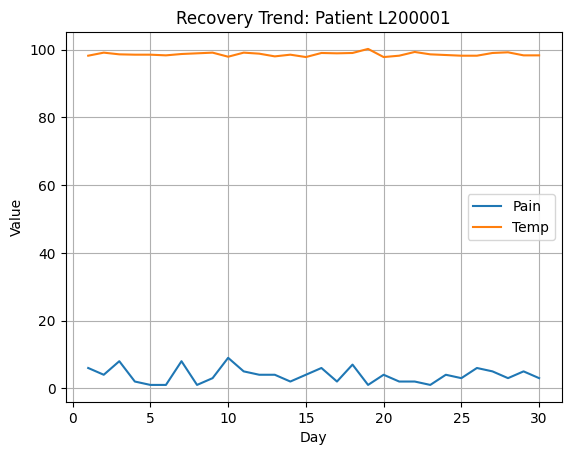

In [56]:
import matplotlib.pyplot as plt

sample_id = df['patient_id'].unique()[0]
sample = df[df['patient_id'] == sample_id]

plt.plot(sample['day'], sample['pain_score'], label='Pain')
plt.plot(sample['day'], sample['temperature'], label='Temp')
plt.title(f"Recovery Trend: Patient {sample_id}")
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


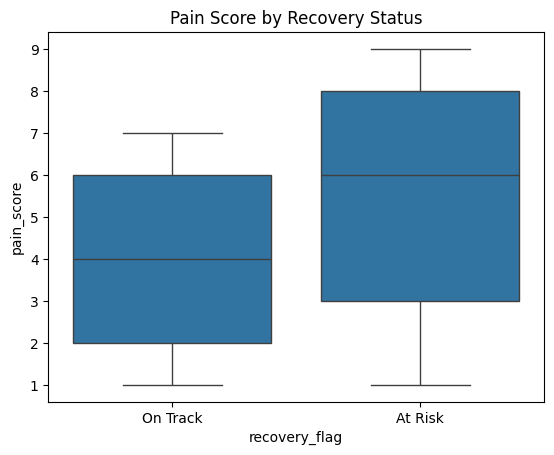

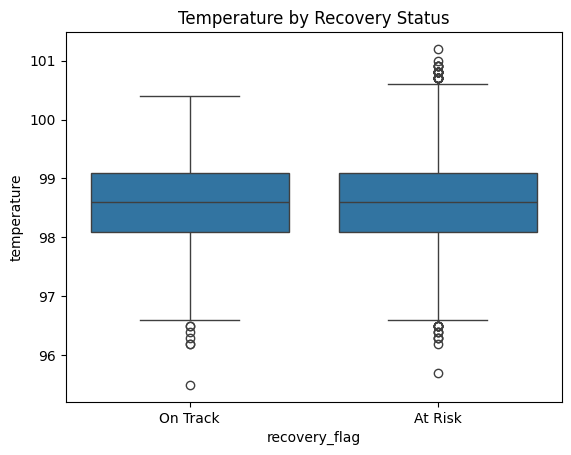

In [57]:
import seaborn as sns

sns.boxplot(data=df, x='recovery_flag', y='pain_score')
plt.title('Pain Score by Recovery Status')
plt.show()

sns.boxplot(data=df, x='recovery_flag', y='temperature')
plt.title('Temperature by Recovery Status')
plt.show()


In [58]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_cols = ['mood', 'wound_check', 'recovery_flag']
encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le

df_encoded['pain_roll3'] = df_encoded.groupby('patient_id')['pain_score'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df_encoded['temp_roll3'] = df_encoded.groupby('patient_id')['temperature'].transform(lambda x: x.rolling(3, min_periods=1).mean())


In [59]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Fit ARIMA to pain score of one patient
sample_series = sample.set_index('day')['pain_score']
model = ARIMA(sample_series, order=(1, 1, 1)).fit()
forecast = model.forecast(steps=5)
print("Next 5 Days Pain Forecast:\n", forecast)


Next 5 Days Pain Forecast:
 30    3.990787
31    3.841555
32    3.864032
33    3.860646
34    3.861156
Name: predicted_mean, dtype: float64


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='f1',  # optimize for F1 to balance precision/recall
    cv=3,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best RF F1 Score:", rf_grid.best_score_)

# Evaluate best model
best_rf = rf_grid.best_estimator_
y_pred_rf_best = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf_best))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Random Forest Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RF F1 Score: 0.662362706072069
              precision    recall  f1-score   support

           0       0.98      0.36      0.53      1794
           1       0.51      0.99      0.67      1206

    accuracy                           0.62      3000
   macro avg       0.75      0.68      0.60      3000
weighted avg       0.79      0.62      0.59      3000



In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

features = ['pain_score', 'temperature', 'sleep_hours', 'pain_roll3', 'temp_roll3']
X = df_encoded[features]
y = df_encoded['recovery_flag']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1794
           1       0.52      0.50      0.51      1206

    accuracy                           0.61      3000
   macro avg       0.60      0.59      0.60      3000
weighted avg       0.61      0.61      0.61      3000



In [62]:
from sklearn.ensemble import GradientBoostingClassifier

# Define parameter grid
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Parameters:", gb_grid.best_params_)
print("Best GB F1 Score:", gb_grid.best_score_)

# Evaluate best model
best_gb = gb_grid.best_estimator_
y_pred_gb_best = best_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb_best))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best GB F1 Score: 0.5192474836617104
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1794
           1       0.51      0.49      0.50      1206

    accuracy                           0.61      3000
   macro avg       0.59      0.59      0.59      3000
weighted avg       0.60      0.61      0.61      3000



In [63]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Results:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68      1794
           1       0.50      0.45      0.47      1206

    accuracy                           0.60      3000
   macro avg       0.58      0.58      0.58      3000
weighted avg       0.59      0.60      0.60      3000



In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

sequence_features = features
n_steps = df_encoded['day'].max()
patient_ids = df_encoded['patient_id'].unique()

X_seq, y_seq = [], []
for pid in patient_ids:
    patient_data = df_encoded[df_encoded['patient_id'] == pid].sort_values('day')
    seq = scaler.transform(patient_data[sequence_features])
    X_seq.append(seq)
    y_seq.append(patient_data['recovery_flag'].values[-1])

X_seq_padded = pad_sequences(X_seq, maxlen=n_steps, padding='post', dtype='float32')
y_seq_encoded = to_categorical(y_seq)

split_idx = int(len(X_seq_padded) * 0.8)
X_train_lstm, X_test_lstm = X_seq_padded[:split_idx], X_seq_padded[split_idx:]
y_train_lstm, y_test_lstm = y_seq_encoded[:split_idx], y_seq_encoded[split_idx:]

model = Sequential([
    LSTM(128, input_shape=(n_steps, len(sequence_features)), return_sequences=False),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_lstm, y_train_lstm, validation_split=0.2, epochs=100, batch_size=64)

loss, acc = model.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Accuracy: {acc:.2f}")


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.4508 - loss: 0.6978 - val_accuracy: 0.6375 - val_loss: 0.6830
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5354 - loss: 0.6915 - val_accuracy: 0.6625 - val_loss: 0.6736
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6687 - loss: 0.6679 - val_accuracy: 0.6625 - val_loss: 0.6649
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6146 - loss: 0.6586 - val_accuracy: 0.6625 - val_loss: 0.6564
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5928 - loss: 0.6578 - val_accuracy: 0.6625 - val_loss: 0.6499
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6312 - loss: 0.6535 - val_accuracy: 0.6625 - val_loss: 0.6456
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5819 - loss: 0.6760 - val_accuracy: 0.6625 - val_loss: 0.6432
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6331 - loss: 0.6580 - val_accuracy: 0.6625 - val_loss:

In [65]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Base XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [66]:
# Define a parameter distribution for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 2, 3]  # use 2 or 3 if complications are rare
}


In [67]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    scoring='f1',
    n_iter=30,             # Number of combinations to try
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_random_search.fit(X_train, y_train)
print("Best XGBoost Parameters:", xgb_random_search.best_params_)
print("Best F1 Score:", xgb_random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost Parameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Best F1 Score: 0.6685073729723308


In [68]:
best_xgb = xgb_random_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print("XGBoost Tuned Model Report:")
print(classification_report(y_test, y_pred_best_xgb))


XGBoost Tuned Model Report:
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      1794
           1       0.51      1.00      0.68      1206

    accuracy                           0.62      3000
   macro avg       0.76      0.68      0.60      3000
weighted avg       0.80      0.62      0.59      3000



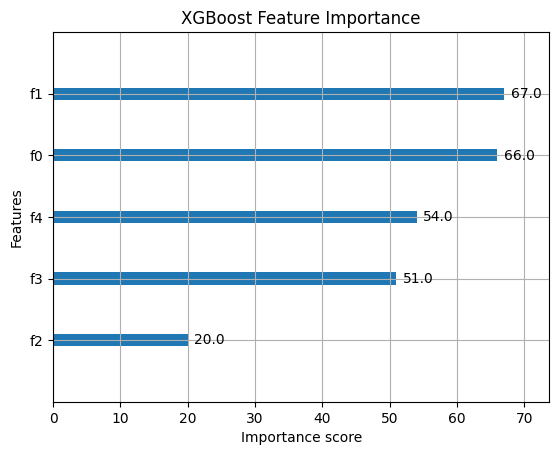

In [69]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(best_xgb)
plt.title("XGBoost Feature Importance")
plt.show()


In [70]:
def alert_logic(row):
    return 1 if row['pain_roll3'] > 7 and row['temp_roll3'] > 100.4 else 0

df_encoded['alert_flag'] = df_encoded.apply(alert_logic, axis=1)
alerts = df_encoded[df_encoded['alert_flag'] == 1]
alerts[['patient_id', 'day', 'pain_roll3', 'temp_roll3', 'alert_flag']].head()


,patient_id,day,pain_roll3,temp_roll3,alert_flag


In [72]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_best_accuracy = accuracy_score(y_test, y_pred_rf_best)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_best_accuracy = accuracy_score(y_test, y_pred_gb_best)
xgb_best_accuracy = accuracy_score(y_test, y_pred_best_xgb)
lstm_accuracy = accuracy_score(y_test_lstm.argmax(axis=1), model.predict(X_test_lstm).argmax(axis=1))

# Print the accuracies
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Best Random Forest Accuracy: {rf_best_accuracy:.2f}")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}")
print(f"Best Gradient Boosting Accuracy: {gb_best_accuracy:.2f}")
print(f"Best XGBoost Accuracy: {xgb_best_accuracy:.2f}")
print(f"LSTM Accuracy: {lstm_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Random Forest Accuracy: 0.61
Best Random Forest Accuracy: 0.62
Gradient Boosting Accuracy: 0.60
Best Gradient Boosting Accuracy: 0.61
Best XGBoost Accuracy: 0.62
LSTM Accuracy: 0.54
